In [65]:
import pandas as pd
import os

# 📌 โหลดข้อมูลจากหลายไฟล์
file_paths = {
    "2024-05-02": "split_data/S50M24_2024-05-02.csv",
    "2024-05-03": "split_data/S50M24_2024-05-03.csv",
    "2024-05-07": "split_data/S50M24_2024-05-07.csv",
    "2024-05-08": "split_data/S50M24_2024-05-08.csv",
    "2024-05-09": "split_data/S50M24_2024-05-09.csv",
    "2024-05-10": "split_data/S50M24_2024-05-10.csv",
    "2024-05-13": "split_data/S50M24_2024-05-13.csv",
    "2024-05-14": "split_data/S50M24_2024-05-14.csv",
}

df_list = {}
for date, file in file_paths.items():
    df = pd.read_csv(file, low_memory=False)
    df["timestamp"] = pd.to_datetime(df["Date"] + " " + df["Time_"])
    
    # 📌 เติมค่าหายไปด้วยค่าก่อนหน้า (Backward Fill)
    df.fillna(method="bfill", inplace=True)

    df_list[date] = df

/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_8975/1275224698.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_8975/1275224698.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_8975/1275224698.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method="bfill", inplace=True)
/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_8975/1275224698.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  

In [67]:
import pandas as pd

# 🟢 โหลดข้อมูลและเรียงลำดับเวลา
file_path = "S50M24_20240502_20240516.csv"  # เปลี่ยนเป็นพาธที่ถูกต้อง
df = pd.read_csv(file_path)

# 🟢 กำหนดช่วง Training & Blind Test
train_start = "2024-05-02"
train_end = "2024-05-14"  # Training: 2-14 พ.ค.
blind_start = "2024-05-15"
blind_end = "2024-05-16"   # Blind Test: 15-16 พ.ค.

# 🟢 แบ่งข้อมูลโดยใช้ Masking (แทน .loc[] เพื่อไม่ต้องใช้ index)
df_train = df[(df['Date'] >= train_start) & (df['Date'] <= train_end)]
df_blind = df[(df['Date'] >= blind_start) & (df['Date'] <= blind_end)]
df = df_train

# รวม Date และ Time_ เพื่อสร้าง Timestamp ที่ถูกต้อง
df['timestamp'] = pd.to_datetime(df['Date'] + ' ' + df['Time_'])

# ตั้งค่า timestamp เป็น Index
df.set_index('timestamp', inplace=True)

# ลบคอลัมน์ Date และ Time_ ที่ไม่จำเป็นแล้ว
df.drop(columns=['Date', 'Time_'], inplace=True)
#df

# Step 1: Data Inspection & Cleaning

                            BidTrade  AskTrade  BidVolume  AskVolume
timestamp                                                           
2024-05-02 09:45:00.001003    836.53       NaN       12.0        NaN
2024-05-02 09:45:00.001003       NaN       NaN        NaN        NaN
2024-05-02 09:45:00.001003       NaN    836.76        NaN       70.0
2024-05-02 09:45:00.034358       NaN       NaN        NaN        NaN
2024-05-02 09:45:00.034402    836.50       NaN       23.0        NaN


/var/folders/hj/vmbgf9dd4tq0dvgjdngp58kw0000gn/T/ipykernel_8975/2190547681.py:9: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  df_resampled = df.resample('15T').agg({


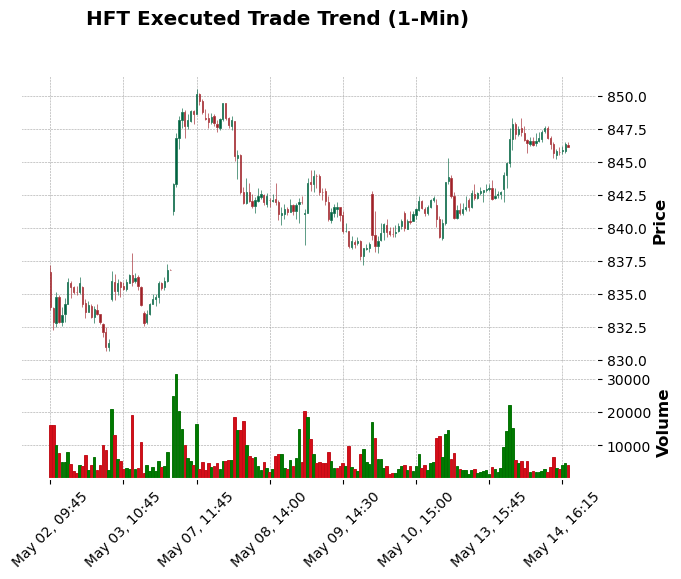

In [70]:
import mplfinance as mpf

# ✅ รวม Date และ Time_ เป็น timestamp

# ✅ ตรวจสอบข้อมูลก่อน Resample
print(df[['BidTrade', 'AskTrade', 'BidVolume', 'AskVolume']].head())

# ✅ ใช้ Flat Aggregation เพื่อหลีกเลี่ยง Nested Renamer
df_resampled = df.resample('15T').agg({
    'BidTrade': ['first', 'last', 'min', 'max'],
    'AskTrade': ['first', 'last', 'min', 'max'],
    'BidVolume': 'sum',
    'AskVolume': 'sum'
}).dropna()

# ✅ เปลี่ยนชื่อคอลัมน์ให้เป็น Single Index
df_resampled.columns = ['Open_Bid', 'Close_Bid', 'Low_Bid', 'High_Bid',
                         'Open_Ask', 'Close_Ask', 'Low_Ask', 'High_Ask',
                         'BidVolume', 'AskVolume']

# ✅ คำนวณ Open, Close, High, Low โดยเฉลี่ยจากฝั่ง Bid และ Ask
df_resampled['Open'] = df_resampled[['Open_Bid', 'Open_Ask']].mean(axis=1)
df_resampled['Close'] = df_resampled[['Close_Bid', 'Close_Ask']].mean(axis=1)
df_resampled['High'] = df_resampled[['High_Bid', 'High_Ask']].max(axis=1)
df_resampled['Low'] = df_resampled[['Low_Bid', 'Low_Ask']].min(axis=1)
df_resampled['Volume'] = df_resampled['BidVolume'] + df_resampled['AskVolume']

# ✅ เลือกเฉพาะคอลัมน์ที่ต้องใช้
df_resampled = df_resampled[['Open', 'High', 'Low', 'Close', 'Volume']]

# ✅ ตรวจสอบโครงสร้าง DataFrame หลังการ Resample
#print(df_resampled.head())

# ✅ พล็อตกราฟแท่งเทียน
mpf.plot(df_resampled, type='candle', volume=True, title='HFT Executed Trade Trend (1-Min)', style='charles')

## Data Inspection & Cleaning

In [73]:
import pandas as pd
import os

# 📌 ตั้งค่าพื้นฐาน
data_folder = "split_data"
file_list = sorted([f for f in os.listdir(data_folder) if f.endswith(".csv")])

# 📌 ตรวจสอบโครงสร้างข้อมูลและ Missing Values
inspection_results = []

for file in file_list:
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)
    
    # ✅ เติมค่า NaN
    df.fillna({"BidTrade": 0, "AskTrade": 0, "BidVolume": 0, "AskVolume": 0}, inplace=True)

    # ✅ ตรวจสอบโครงสร้างข้อมูล
    missing_values = df.isna().sum().sum()
    total_rows = len(df)

    inspection_results.append({
        "File": file,
        "Total Rows": total_rows,
        "Missing Values": missing_values,
        "Missing Percentage": (missing_values / (total_rows * len(df.columns))) * 100
    })

# 📌 แสดงผลลัพธ์
df_inspection_summary = pd.DataFrame(inspection_results)
import ace_tools_open as ace
ace.display_dataframe_to_user(name="Data Inspection Summary", dataframe=df_inspection_summary)


Data Inspection Summary


# Step 2 : Market Structure Analysis (วิเคราะห์โครงสร้างตลาด)

### Basic Spread Distribution

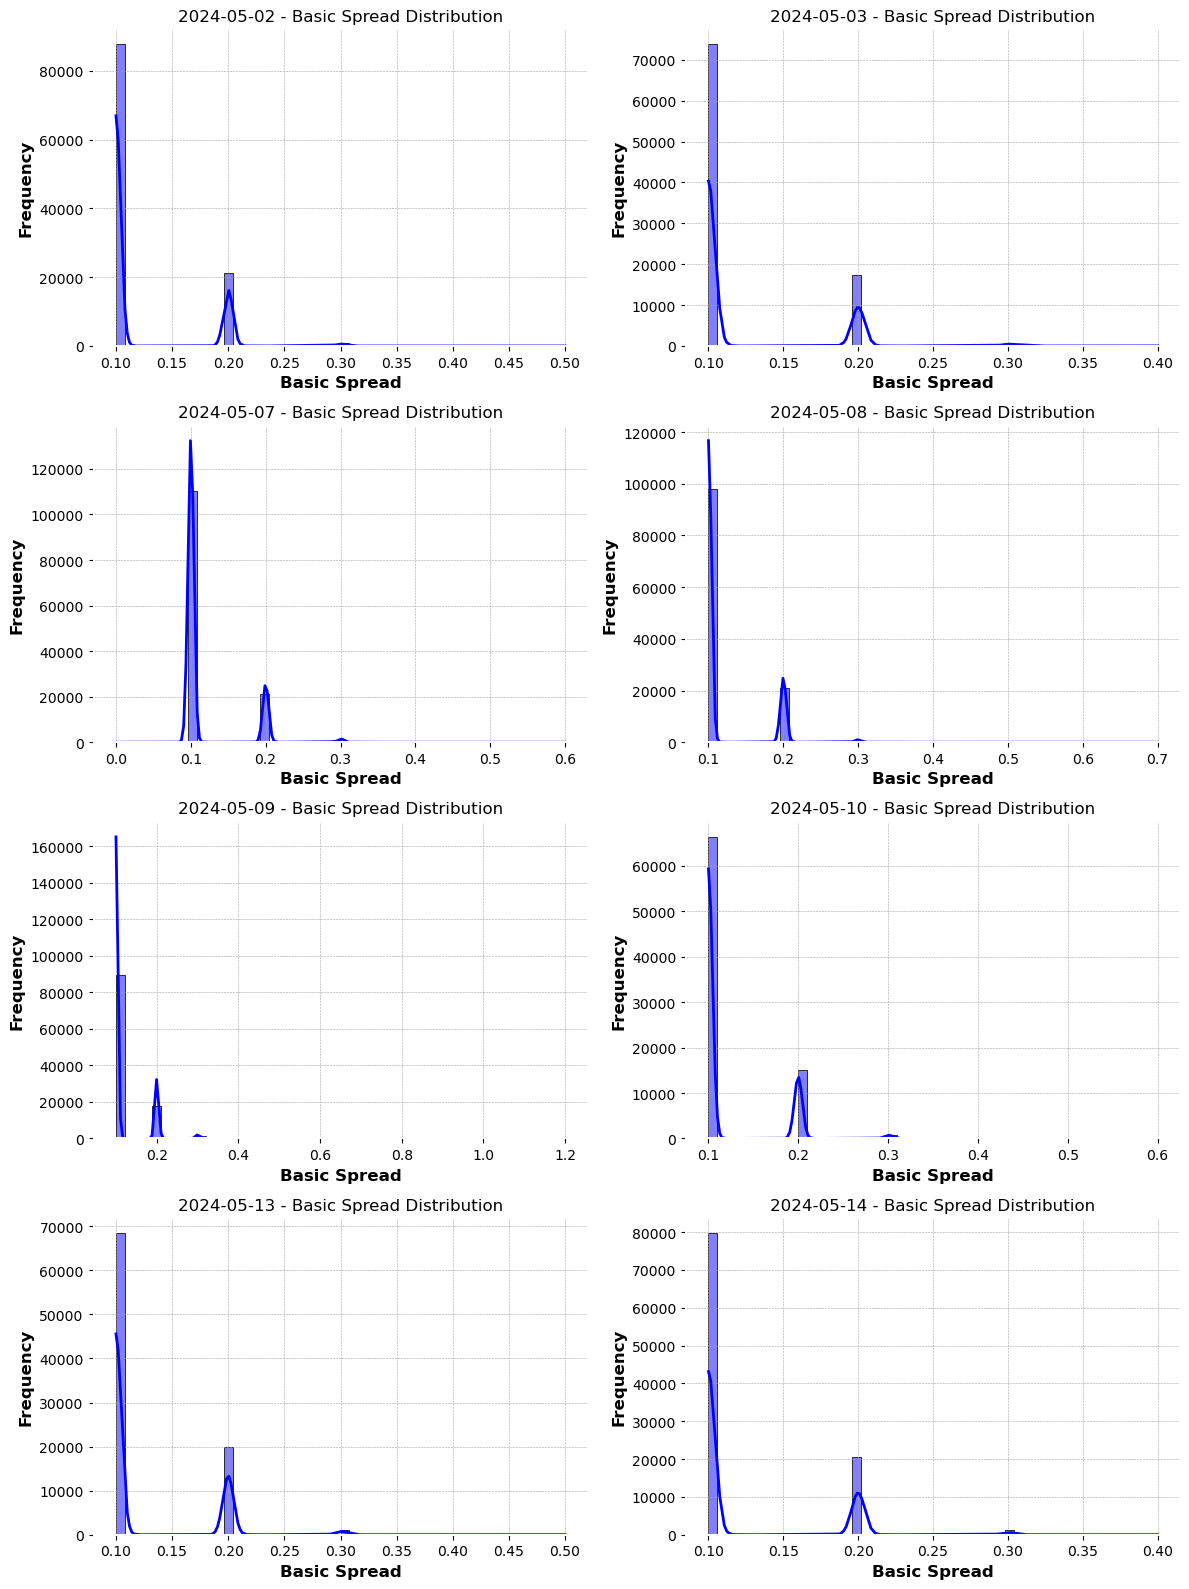

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for ax, (date, df) in zip(axes.flat, df_list.items()):
    df["Basic Spread"] = df["Ask1"] - df["Bid1"]
    sns.histplot(df["Basic Spread"].dropna(), bins=50, kde=True, color="blue", ax=ax)
    ax.set_title(f"{date} - Basic Spread Distribution")
    ax.set_xlabel("Basic Spread")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

### VWAP Spread Distribution

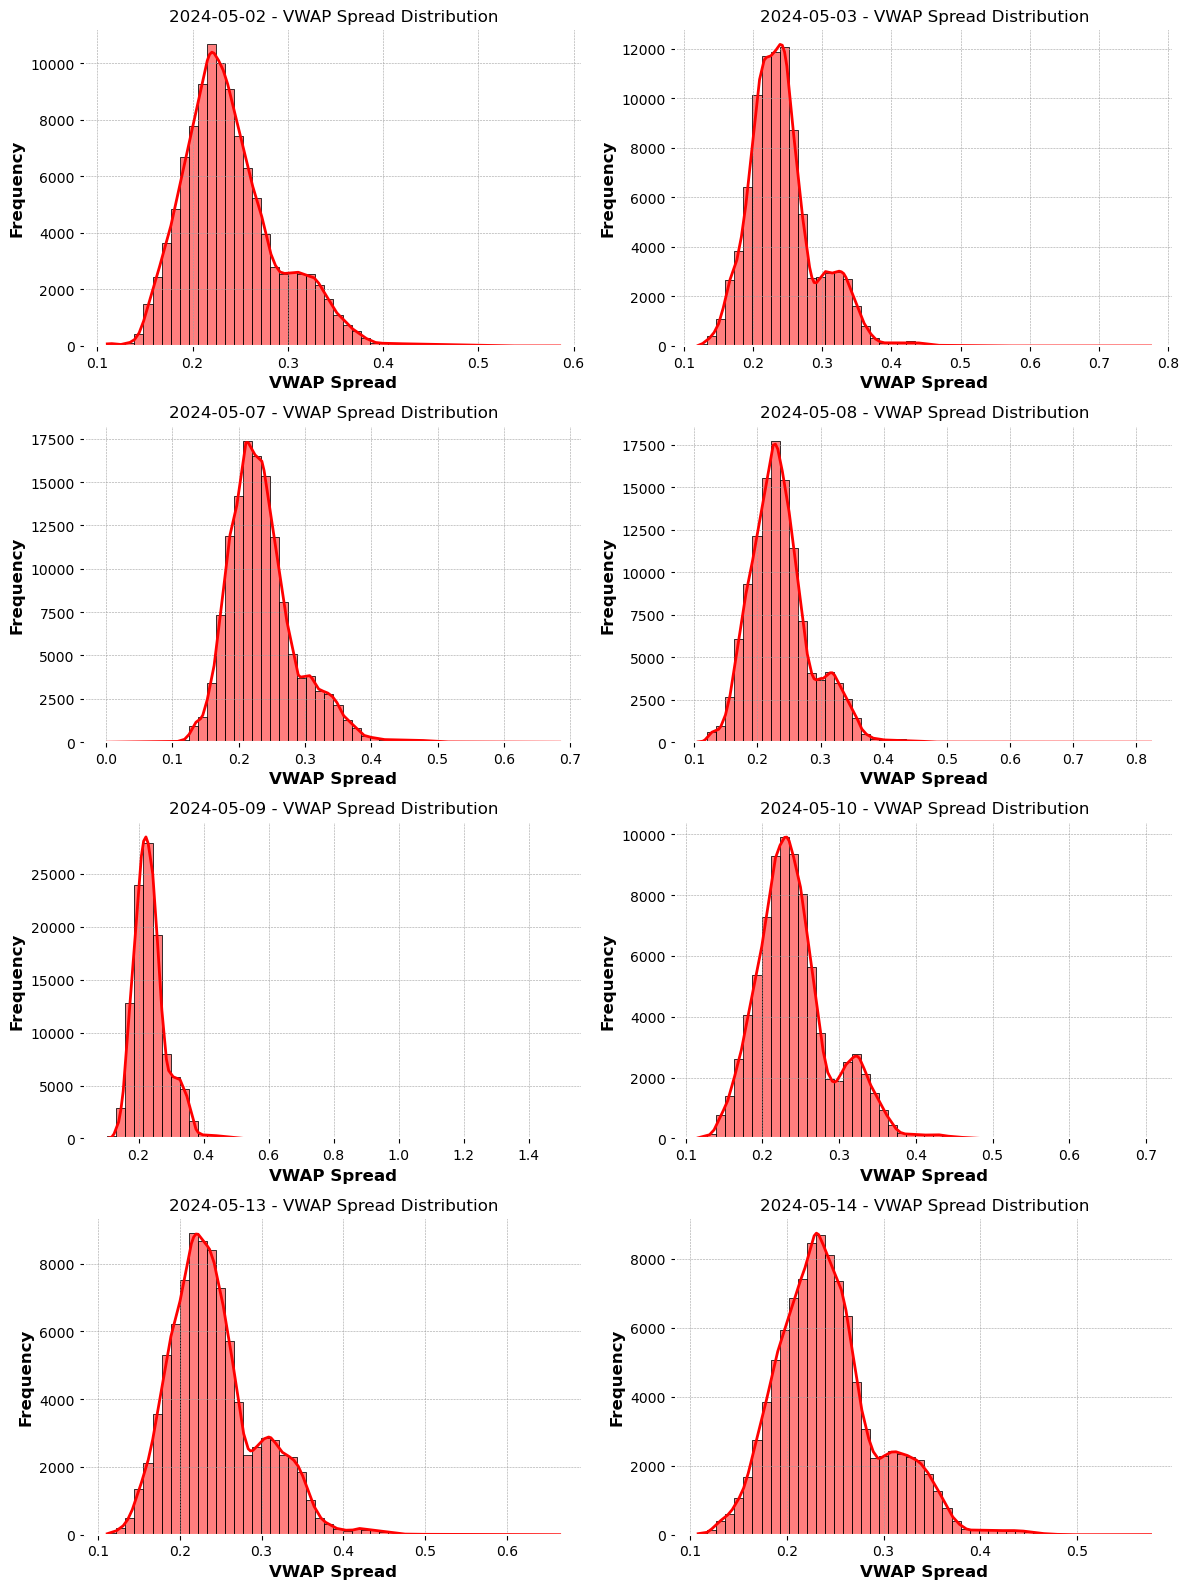

In [94]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for ax, (date, df) in zip(axes.flat, df_list.items()):
    df["VWAP_Bid"] = (df["Bid1"] * df["vBid1"] + df["Bid2"] * df["vBid2"]) / (df["vBid1"] + df["vBid2"])
    df["VWAP_Ask"] = (df["Ask1"] * df["vAsk1"] + df["Ask2"] * df["vAsk2"]) / (df["vAsk1"] + df["vAsk2"])
    df["VWAP_Spread"] = df["VWAP_Ask"] - df["VWAP_Bid"]

    sns.histplot(df["VWAP_Spread"].dropna(), bins=50, kde=True, color="red", ax=ax)
    ax.set_title(f"{date} - VWAP Spread Distribution")
    ax.set_xlabel("VWAP Spread")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 3 : Order Flow & Liquidity Analysis (วิเคราะห์กระแสคำสั่งซื้อขายและสภาพคล่อง)

### Order Book Imbalance (OBI) & Liquidity Shock

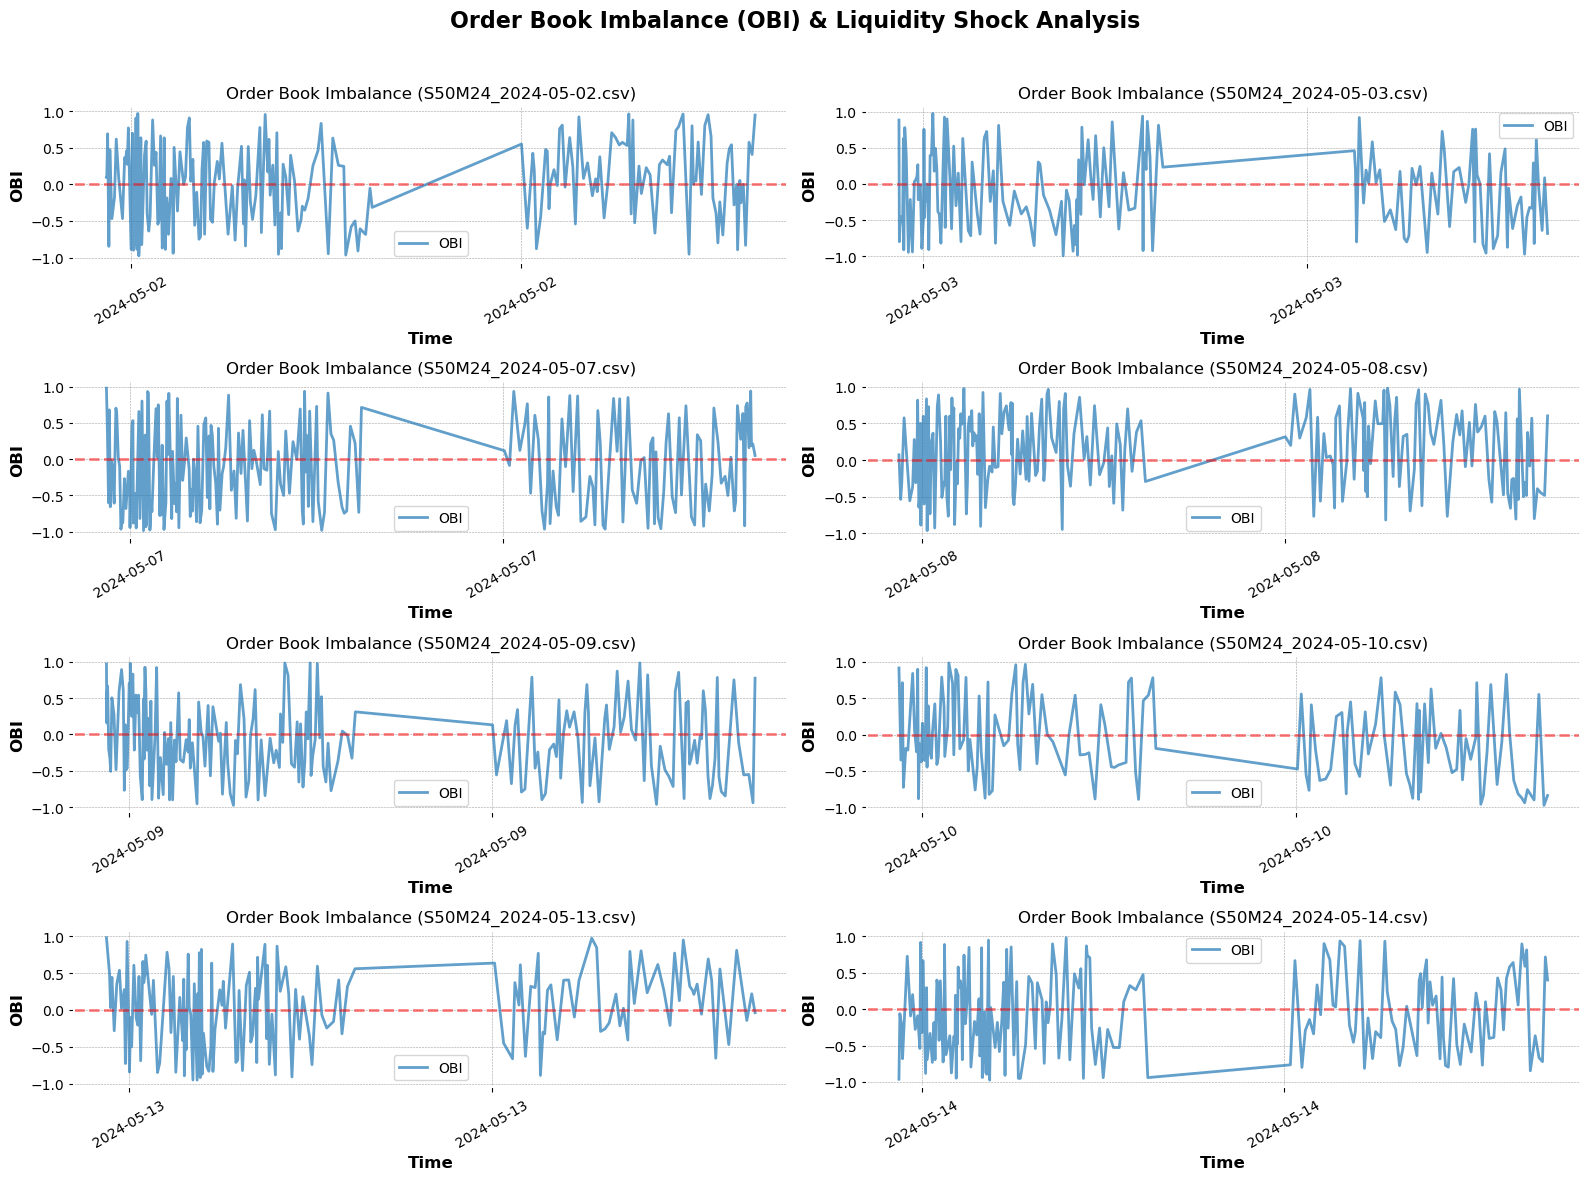

Order Book Imbalance Summary


In [96]:
# 📌 เก็บผลลัพธ์
obi_stats = []

# 📌 กำหนดขนาดกราฟ (4x2 Multi-Plot)
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle("Order Book Imbalance (OBI) & Liquidity Shock Analysis", fontsize=16)

for idx, file in enumerate(file_list):
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)

    # ✅ คำนวณ Order Book Imbalance (OBI)
    df["OBI"] = (df["vBid1"] - df["vAsk1"]) / (df["vBid1"] + df["vAsk1"])

    # ✅ คำนวณ % การเปลี่ยนแปลงของ Volume (Liquidity Shock)
    df["Liquidity Shock"] = df["vBid1"].pct_change() + df["vAsk1"].pct_change()

    # ✅ ค่าสถิติของ OBI
    obi_data = {
        "File": file,
        "Avg OBI": df["OBI"].mean(),
        "Std OBI": df["OBI"].std(),
        "Avg Liquidity Shock": df["Liquidity Shock"].mean(),
        "Max Liquidity Shock": df["Liquidity Shock"].max()
    }
    obi_stats.append(obi_data)

    # ✅ ลดขนาดข้อมูลโดยสุ่มเลือก 1000 จุด (ถ้ามีมากกว่านั้น) และสร้างสำเนาใหม่
    df_sampled = df.iloc[::500].copy() if len(df) > 5000 else df.copy()

    # ✅ ใช้ .loc[] เพื่อแปลง timestamp เป็น datetime
    df_sampled.loc[:, "timestamp"] = pd.to_datetime(df_sampled["timestamp"])

    # ✅ วาดกราฟ OBI
    ax = axes[idx // 2, idx % 2]
    ax.plot(df_sampled["timestamp"], df_sampled["OBI"], label="OBI", alpha=0.7)
    ax.axhline(0, color="red", linestyle="--", alpha=0.5)
    ax.set_title(f"Order Book Imbalance ({file})")
    ax.set_xlabel("Time")
    ax.set_ylabel("OBI")
    ax.legend()
    
    # ✅ ปรับแกนเวลาให้โหลดเร็วขึ้น
    ax.set_xticks(ax.get_xticks()[::4])
    ax.tick_params(axis="x", rotation=30)

# 📌 ปรับ Layout และแสดงกราฟ
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 📌 แสดงผลลัพธ์ OBI Summary
df_obi_summary = pd.DataFrame(obi_stats)
import ace_tools_open as ace
ace.display_dataframe_to_user(name="Order Book Imbalance Summary", dataframe=df_obi_summary)

### Market Impact of Large Trades

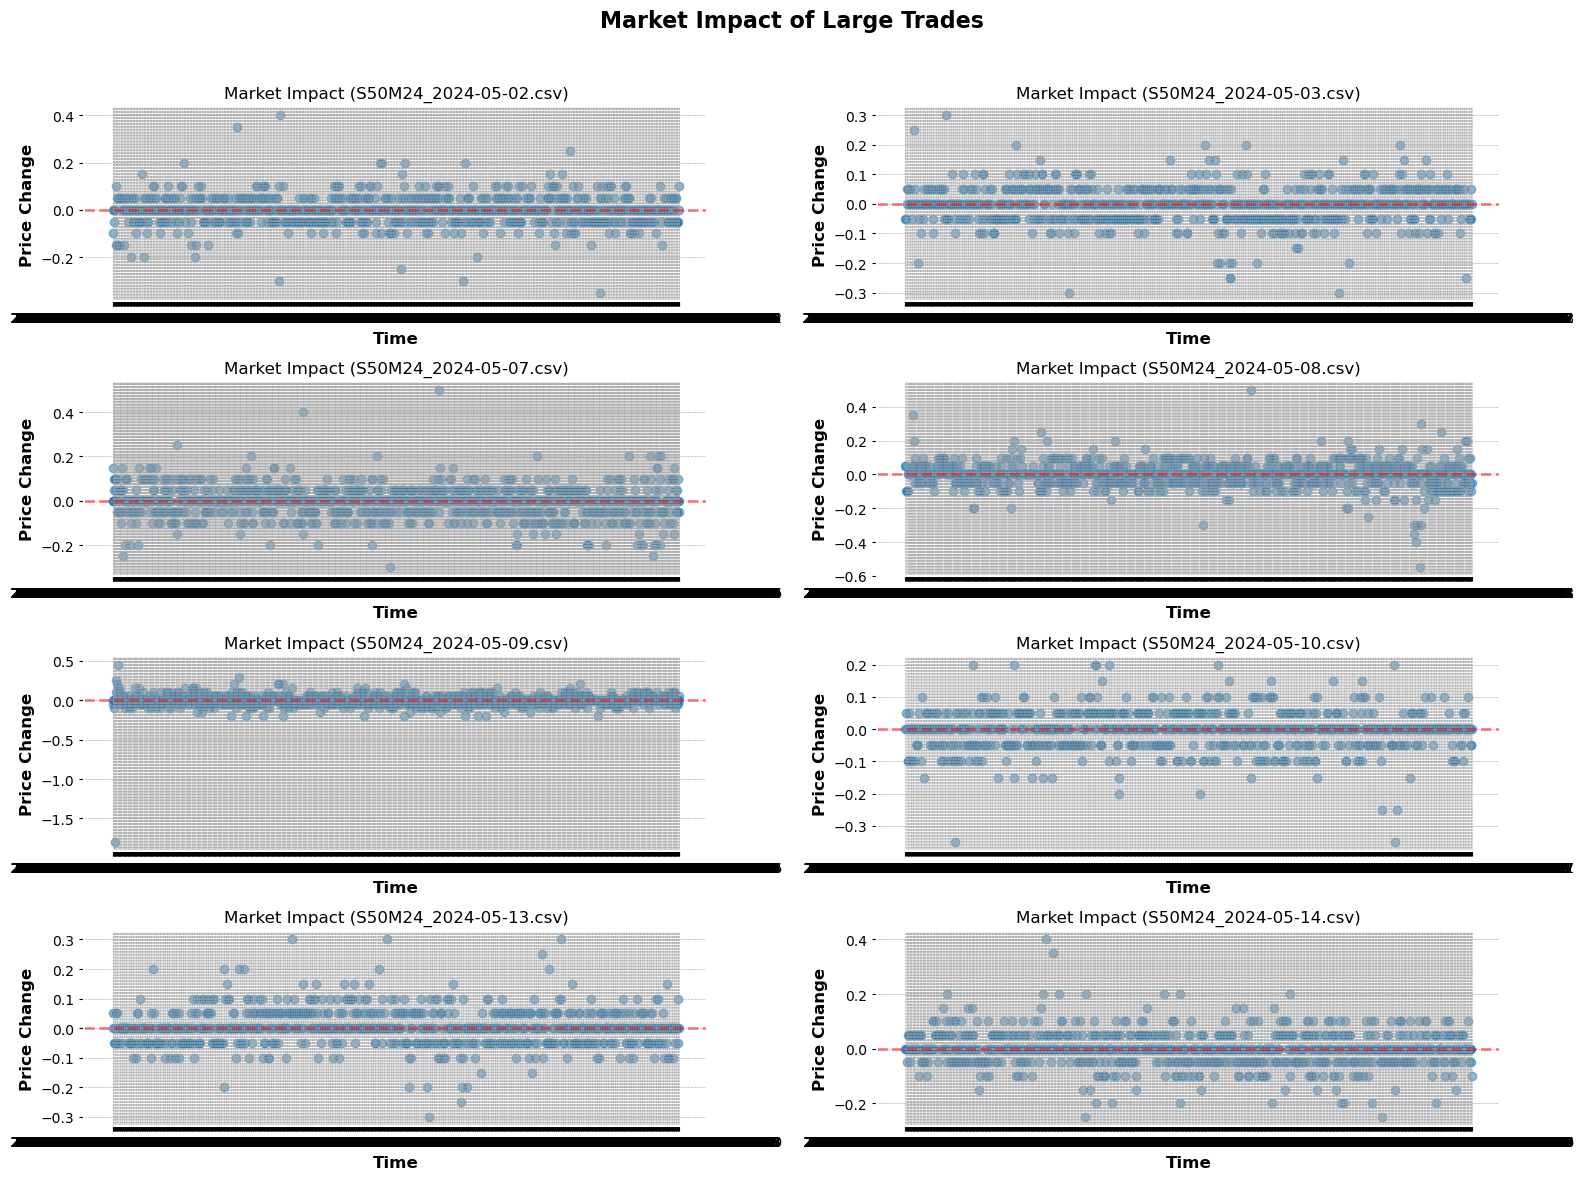

Market Impact Analysis


In [98]:
# 📌 เก็บผลลัพธ์
impact_stats = []

# 📌 กำหนดขนาดกราฟ (4x2 Multi-Plot)
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle("Market Impact of Large Trades", fontsize=16)

for idx, file in enumerate(file_list):
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)

    # ✅ คำนวณ Mid-Price
    df["MidPrice"] = (df["Bid1"] + df["Ask1"]) / 2

    # ✅ หาค่าเปลี่ยนแปลงของ Mid-Price หลังจาก Large Trade
    df["Price Change"] = df["MidPrice"].diff()
    
    # ✅ คัดเลือก Large Trades (Top 5% ของ Volume)
    large_trades = df[(df["BidVolume"] > df["BidVolume"].quantile(0.95)) | 
                      (df["AskVolume"] > df["AskVolume"].quantile(0.95))]
    
    avg_price_change = large_trades["Price Change"].mean()
    
    impact_stats.append({
        "File": file,
        "Avg Price Change After Large Trade": avg_price_change
    })
    
    # ✅ Plot the impact
    ax = axes[idx // 2, idx % 2]
    ax.scatter(large_trades["timestamp"], large_trades["Price Change"], alpha=0.5)
    ax.axhline(0, color="red", linestyle="--", alpha=0.5)
    ax.set_title(f"Market Impact ({file})")
    ax.set_xlabel("Time")
    ax.set_ylabel("Price Change")

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 📌 แสดงผลลัพธ์ Market Impact Summary
df_impact_summary = pd.DataFrame(impact_stats)
ace.display_dataframe_to_user(name="Market Impact Analysis", dataframe=df_impact_summary)

### Slippage Impact

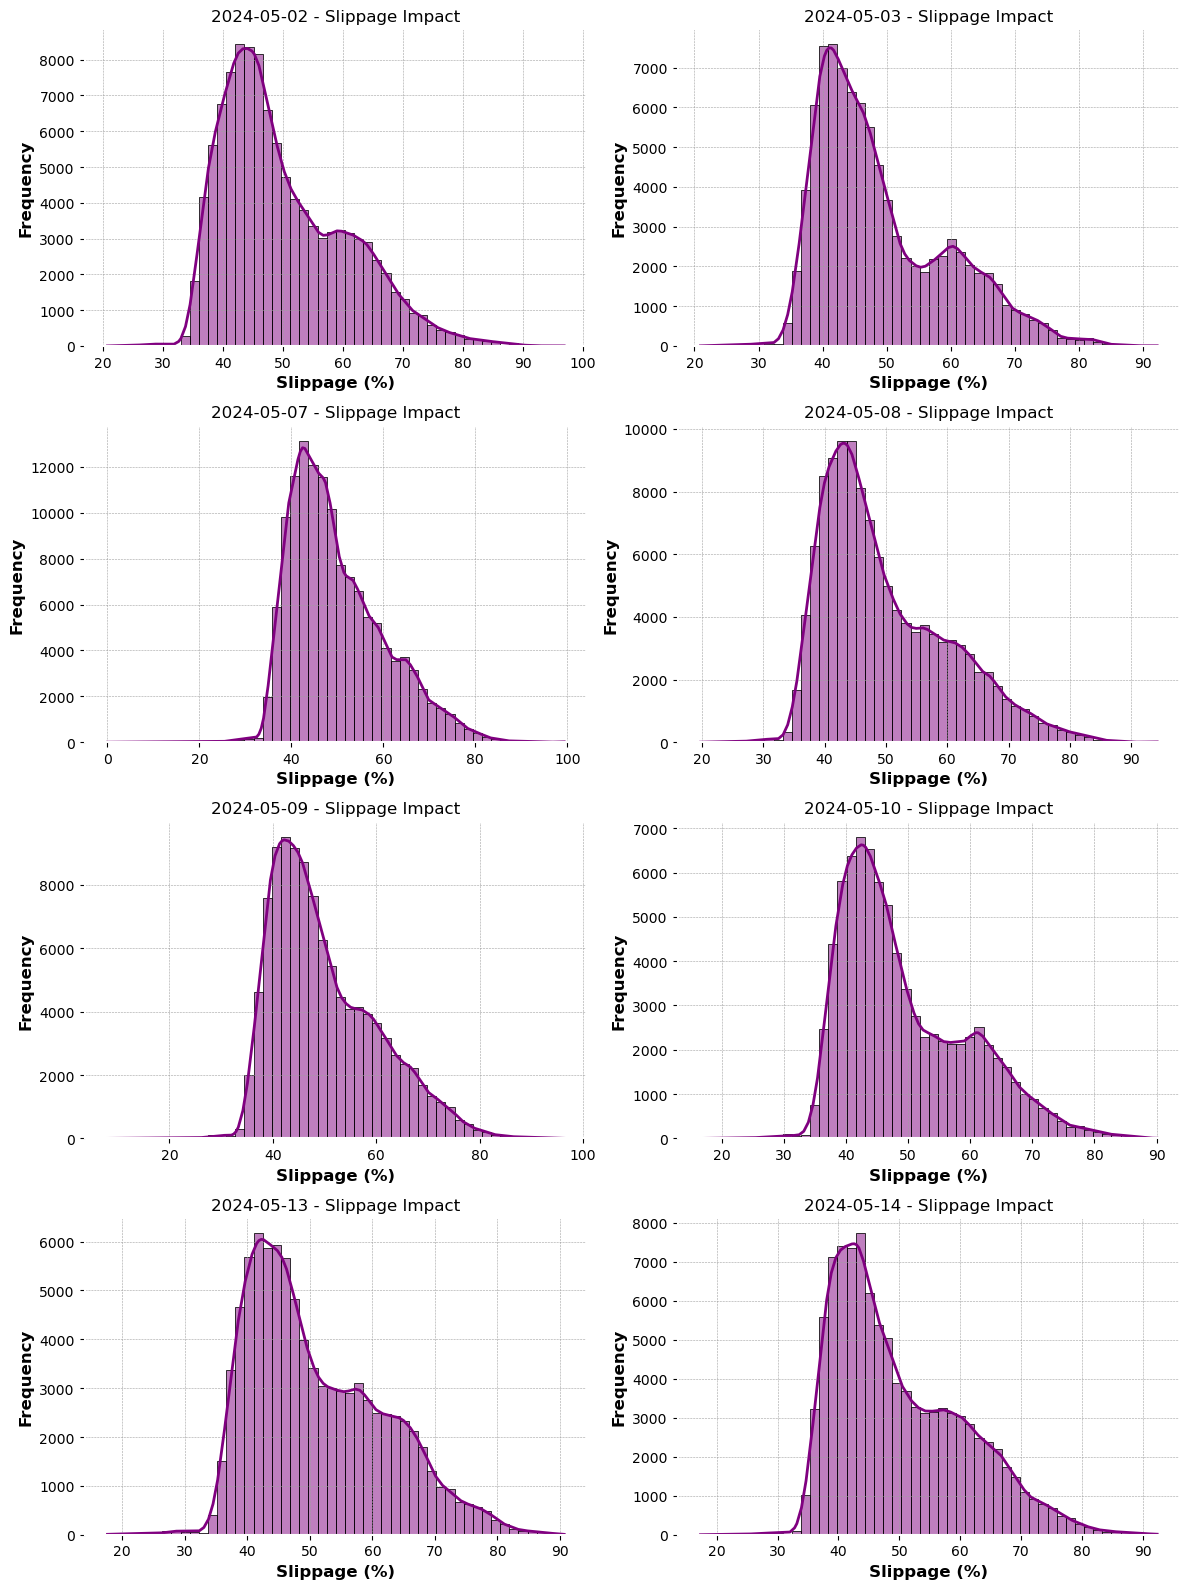

In [107]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

for ax, (date, df) in zip(axes.flat, df_list.items()):
    df["Slippage Impact"] = ((df["Ask1"] - df["Bid1"]) / df["VWAP_Spread"]) * 100
    sns.histplot(df["Slippage Impact"].dropna(), bins=50, kde=True, color="purple", ax=ax)
    ax.set_title(f"{date} - Slippage Impact")
    ax.set_xlabel("Slippage (%)")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()

# Step 4 : Price Behavior & Statistical Analysis (วิเคราะห์พฤติกรรมราคาและสถิติ)

### Return Distribution & Volatility Analysis

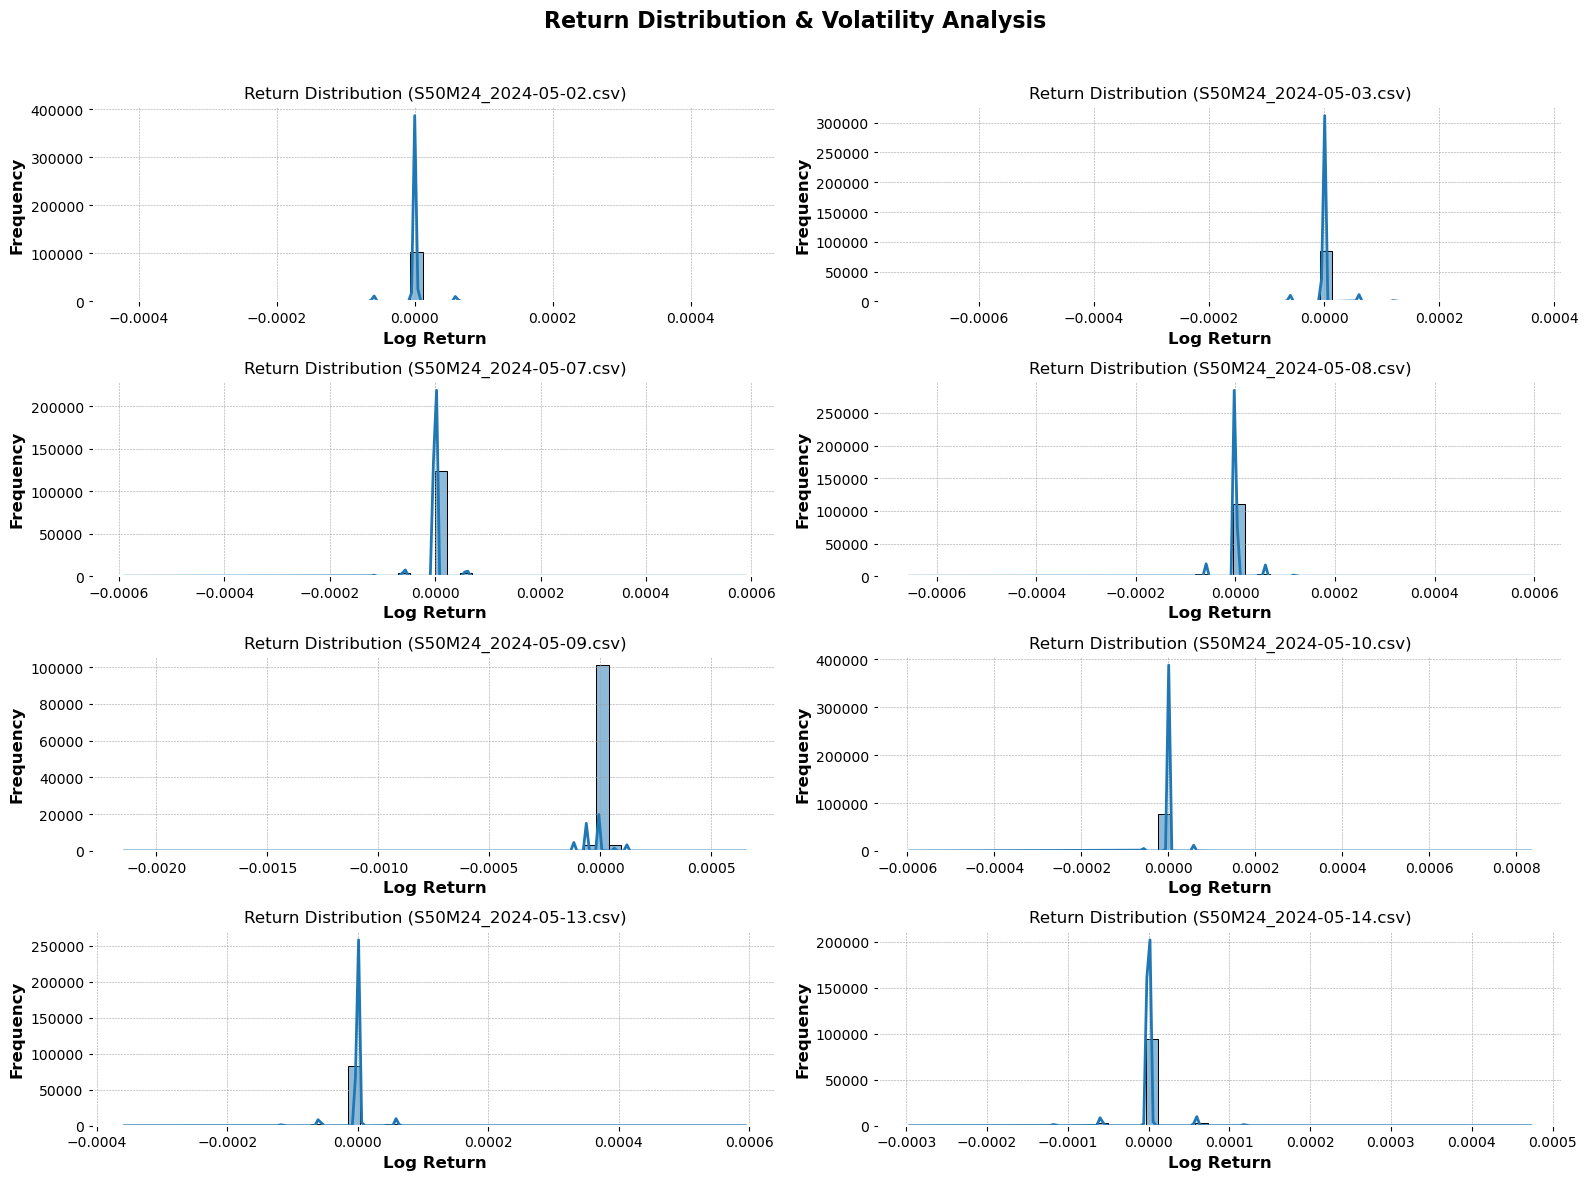

Return & Volatility Summary


In [100]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📌 เก็บผลลัพธ์
returns_summary = []
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle("Return Distribution & Volatility Analysis", fontsize=16)

for idx, file in enumerate(file_list):
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)

    # ✅ คำนวณ Log Returns
    df["MidPrice"] = (df["Bid1"] + df["Ask1"]) / 2
    df["LogReturn"] = np.log(df["MidPrice"] / df["MidPrice"].shift(1))

    # ✅ คำนวณสถิติของ Returns
    mean_return = df["LogReturn"].mean()
    std_return = df["LogReturn"].std()
    
    returns_summary.append({
        "File": file,
        "Mean Return": mean_return,
        "Std Dev Return": std_return
    })
    
    # ✅ วาด Histogram ของ Returns
    ax = axes[idx // 2, idx % 2]
    sns.histplot(df["LogReturn"].dropna(), bins=50, kde=True, ax=ax)
    ax.set_title(f"Return Distribution ({file})")
    ax.set_xlabel("Log Return")
    ax.set_ylabel("Frequency")

# 📌 แสดงกราฟ
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 📌 แสดงผลลัพธ์ตาราง Return Summary
df_returns_summary = pd.DataFrame(returns_summary)
ace.display_dataframe_to_user(name="Return & Volatility Summary", dataframe=df_returns_summary)

### Autocorrelation Analysis (ACF)

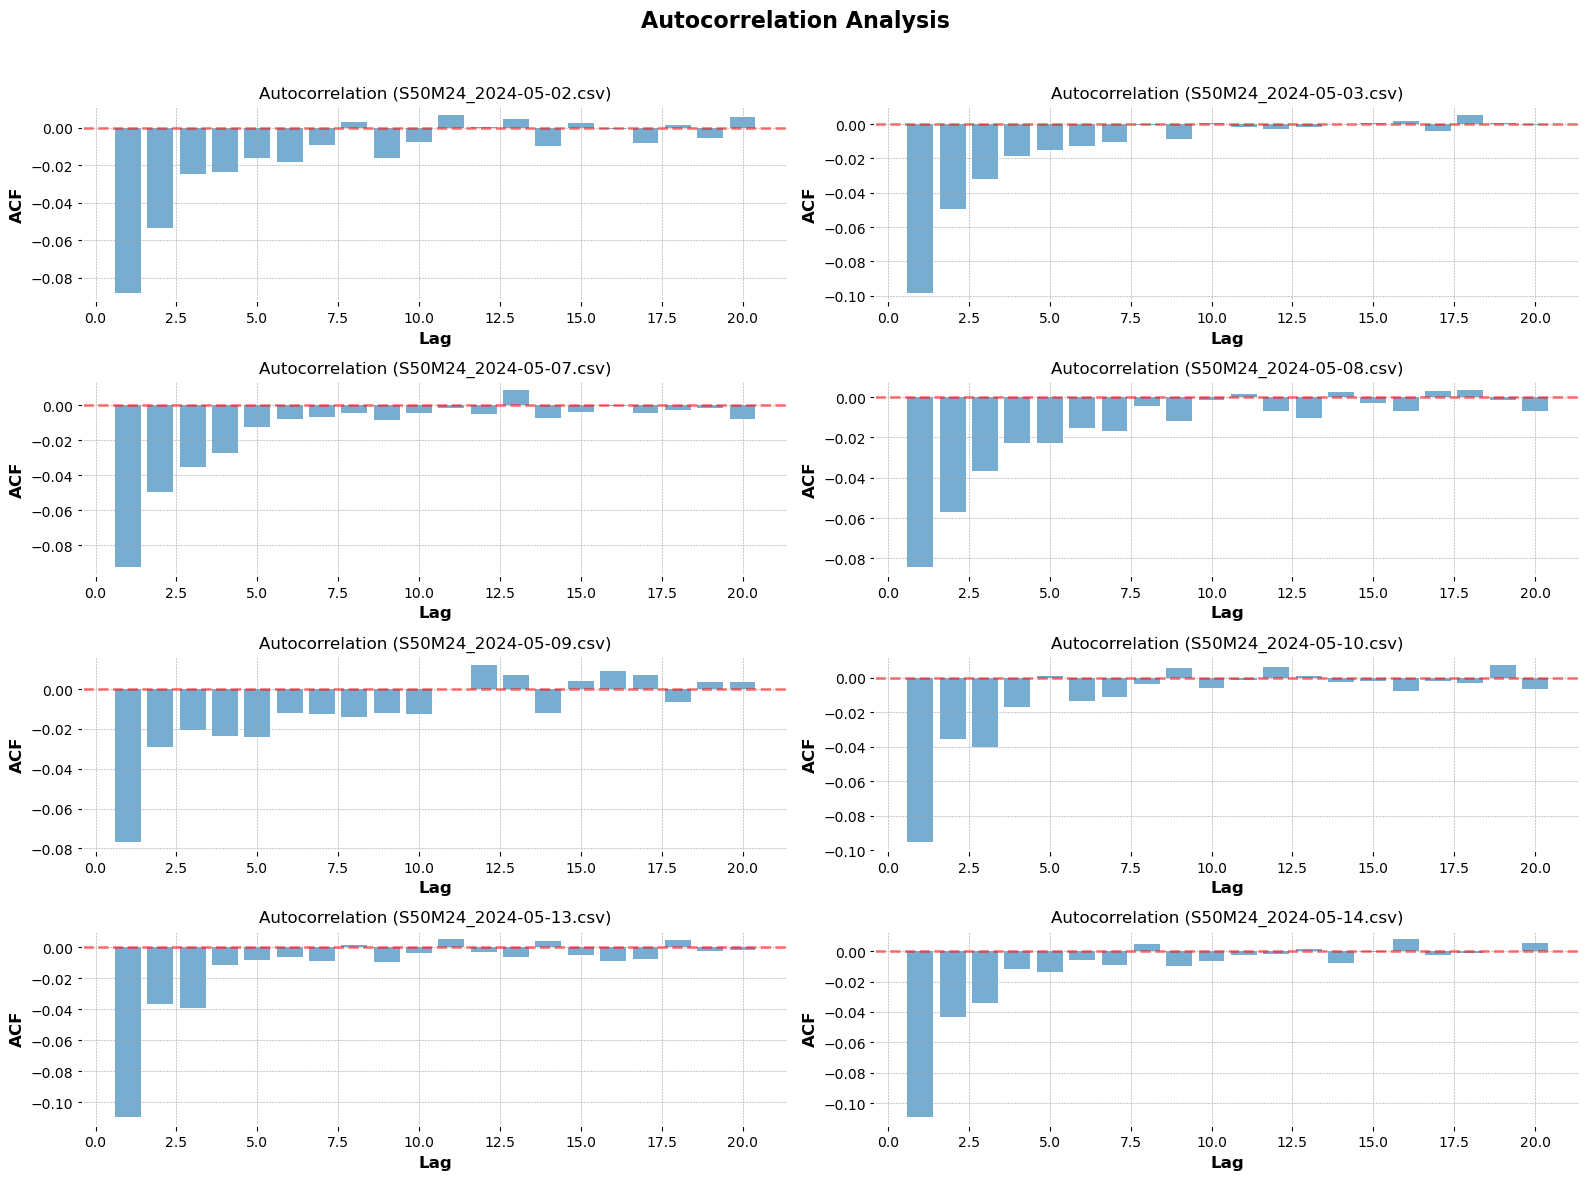

Autocorrelation Summary


In [102]:
from statsmodels.tsa.stattools import acf, pacf

# 📌 เก็บผลลัพธ์
autocorr_summary = []
fig, axes = plt.subplots(4, 2, figsize=(16, 12))
fig.suptitle("Autocorrelation Analysis", fontsize=16)

for idx, file in enumerate(file_list):
    file_path = os.path.join(data_folder, file)
    df = pd.read_csv(file_path)

    # ✅ คำนวณ Autocorrelation
    df["MidPrice"] = (df["Bid1"] + df["Ask1"]) / 2
    df["LogReturn"] = np.log(df["MidPrice"] / df["MidPrice"].shift(1))

    acf_values = acf(df["LogReturn"].dropna(), nlags=20)

    # ✅ เก็บค่า Autocorrelation ของ Lag 1-5
    autocorr_summary.append({
        "File": file,
        "ACF Lag 1": acf_values[1],
        "ACF Lag 2": acf_values[2],
        "ACF Lag 3": acf_values[3]
    })
    
    # ✅ วาดกราฟ Autocorrelation
    ax = axes[idx // 2, idx % 2]
    ax.bar(range(1, len(acf_values)), acf_values[1:], alpha=0.6)
    ax.axhline(0, color="red", linestyle="--", alpha=0.5)
    ax.set_title(f"Autocorrelation ({file})")
    ax.set_xlabel("Lag")
    ax.set_ylabel("ACF")

# 📌 แสดงกราฟ
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# 📌 แสดงผลลัพธ์ Autocorrelation Summary
df_autocorr_summary = pd.DataFrame(autocorr_summary)
ace.display_dataframe_to_user(name="Autocorrelation Summary", dataframe=df_autocorr_summary)

### VWAP Spread Quantile Analysis

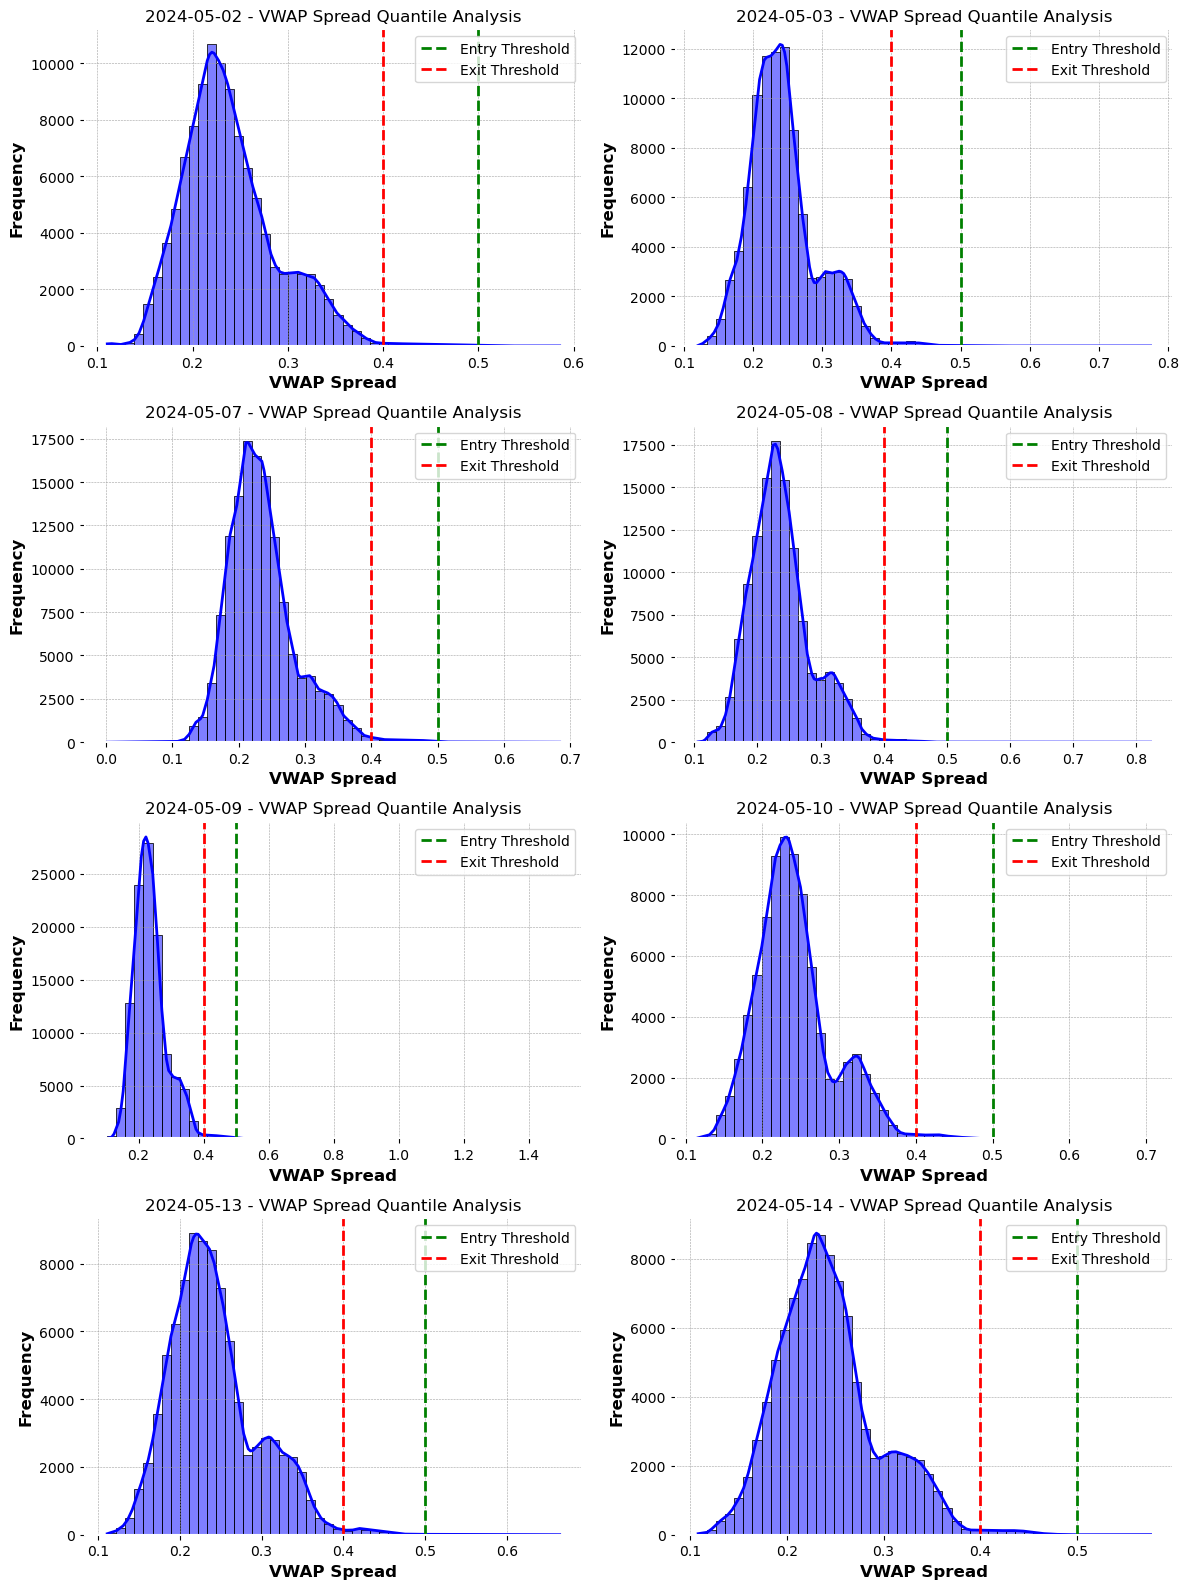

In [104]:
fig, axes = plt.subplots(4, 2, figsize=(12, 16))

entry_threshold = 0.5
exit_threshold = 0.4

for ax, (date, df) in zip(axes.flat, df_list.items()):
    sns.histplot(df["VWAP_Spread"].dropna(), bins=50, kde=True, color="blue", ax=ax)
    ax.axvline(entry_threshold, color="green", linestyle="--", label="Entry Threshold")
    ax.axvline(exit_threshold, color="red", linestyle="--", label="Exit Threshold")
    ax.legend()
    ax.set_title(f"{date} - VWAP Spread Quantile Analysis")
    ax.set_xlabel("VWAP Spread")
    ax.set_ylabel("Frequency")

plt.tight_layout()
plt.show()


# Step 5 : Choosing the Strategy

# EDA เพิ่มเติม

### AVG Slippage

In [129]:
import pandas as pd
import numpy as np

# 📌 รายชื่อไฟล์ข้อมูล (สามารถเพิ่มให้ครบ 8 ไฟล์ได้)
file_paths = [
    "split_data/S50M24_2024-05-02.csv",
    "split_data/S50M24_2024-05-03.csv",
    "split_data/S50M24_2024-05-07.csv",
    "split_data/S50M24_2024-05-08.csv",
    "split_data/S50M24_2024-05-09.csv",
    "split_data/S50M24_2024-05-10.csv",
    "split_data/S50M24_2024-05-13.csv",
    "split_data/S50M24_2024-05-14.csv",
]

# 📌 ฟังก์ชันคำนวณ Slippage
def calculate_slippage(df):
    df["Slippage"] = df["Ask1"] - df["Bid1"]
    return df["Slippage"].mean()  # ค่าเฉลี่ยของ Slippage ที่ใช้ใน Backtest

# 📌 เก็บผลลัพธ์ Slippage
results_slippage = []

# 📌 วนลูปประมวลผลไฟล์ทั้งหมด
for file_path in file_paths:
    df = pd.read_csv(file_path)

    # ✅ ตรวจสอบว่ามีคอลัมน์ที่ต้องใช้หรือไม่
    required_columns = {"Bid1", "Ask1"}
    if not required_columns.issubset(df.columns):
        print(f"❌ Missing required columns in {file_path}")
        continue

    # ✅ คำนวณค่าเฉลี่ยของ Slippage
    avg_slippage = calculate_slippage(df)

    # ✅ เก็บค่าผลลัพธ์สำหรับ Backtest
    results_slippage.append({
        "File": file_path.split("/")[-1],
        "Avg Slippage (%)": round(avg_slippage, 5)
    })

# 📌 แสดงผลลัพธ์ใน DataFrame
df_results_slippage = pd.DataFrame(results_slippage)
tools.display_dataframe_to_user(name="Backtest Slippage Summary", dataframe=df_results_slippage)


Backtest Slippage Summary


### AVG Market Impact

In [135]:
# 📌 ฟังก์ชันคำนวณ Market Impact
def calculate_market_impact(df):
    df["MidPrice"] = (df["Bid1"] + df["Ask1"]) / 2
    df["MarketImpact"] = df["MidPrice"].diff()
    return df["MarketImpact"].mean() * 100  # คิดเป็นเปอร์เซ็นต์

# 📌 เก็บผลลัพธ์ Market Impact
results_market_impact = []

# 📌 วนลูปประมวลผลไฟล์ทั้งหมด
for file_path in file_paths:
    df = pd.read_csv(file_path)

    # ✅ ตรวจสอบว่ามีคอลัมน์ที่ต้องใช้หรือไม่
    required_columns = {"Bid1", "Ask1"}
    if not required_columns.issubset(df.columns):
        print(f"❌ Missing required columns in {file_path}")
        continue

    # ✅ คำนวณค่าเฉลี่ยของ Market Impact
    avg_market_impact = calculate_market_impact(df)

    # ✅ เก็บค่าผลลัพธ์สำหรับ Backtest
    results_market_impact.append({
        "File": file_path.split("/")[-1],
        "Avg Market Impact (%)": round(avg_market_impact, 5)
    })

# 📌 แสดงผลลัพธ์ใน DataFrame
df_results_market_impact = pd.DataFrame(results_market_impact)
tools.display_dataframe_to_user(name="Backtest Market Impact Summary", dataframe=df_results_market_impact)


Backtest Market Impact Summary


### Fill Rate

In [38]:
import ace_tools_open as tools
# 📌 ฟังก์ชันคำนวณ Fill Rate สำหรับแต่ละไฟล์
def calculate_fill_rate(order_book_path, trade_log_path):
    try:
        # 📌 โหลดไฟล์
        order_book_df = pd.read_csv(order_book_path)
        trade_log_df = pd.read_csv(trade_log_path)

        # 📌 ปรับชื่อคอลัมน์ให้เป็นตัวพิมพ์เล็กเพื่อป้องกัน Case-Sensitivity
        order_book_df.columns = order_book_df.columns.str.strip().str.lower()
        trade_log_df.columns = trade_log_df.columns.str.strip().str.lower()

        # ✅ ตรวจสอบว่ามีคอลัมน์ที่ต้องใช้ครบหรือไม่
        required_columns_trade_log = {"timestamp", "type"}
        required_columns_order_book = {"timestamp", "bidtrade", "asktrade"}

        if not required_columns_trade_log.issubset(trade_log_df.columns) or not required_columns_order_book.issubset(order_book_df.columns):
            print(f"❌ Missing required columns in {order_book_path} or {trade_log_path}")
            return None

        # ✅ รวม Order Book กับ Trade Log ตาม Timestamp (ไม่ใช้ Price)
        merged_df = trade_log_df.merge(order_book_df[["timestamp", "bidtrade", "asktrade"]], on="timestamp", how="left")

        # ✅ คำนวณ Fill Rate
        total_orders = len(trade_log_df)

        # ตรวจสอบ Fill Rate ที่ Bid1 และ Ask1 (ใช้แค่ Timestamp + BidTrade/AskTrade)
        #bid1_trades = merged_df[merged_df["bidtrade"] > 0]
        #ask1_trades = merged_df[merged_df["asktrade"] > 0]

        #bid1_fill_rate = len(bid1_trades) / total_orders * 100
        #ask1_fill_rate = len(ask1_trades) / total_orders * 100

        # ตรวจสอบ Fill Rate ตามประเภทคำสั่ง (ใช้แค่ Timestamp + BidTrade/AskTrade)
        open_long_fill = len(merged_df[(merged_df["type"] == "OPEN_LONG") & (merged_df["bidtrade"] > 0)]) / len(merged_df[(merged_df["type"] == "OPEN_LONG")]) * 100
        close_short_fill = len(merged_df[(merged_df["type"] == "CLOSE_SHORT") & (merged_df["bidtrade"] > 0)]) / len(merged_df[(merged_df["type"] == "CLOSE_SHORT")]) * 100
        open_short_fill = len(merged_df[(merged_df["type"] == "OPEN_SHORT") & (merged_df["asktrade"] > 0)]) / len(merged_df[(merged_df["type"] == "OPEN_SHORT")]) * 100
        close_long_fill = len(merged_df[(merged_df["type"] == "CLOSE_LONG") & (merged_df["asktrade"] > 0)]) / len(merged_df[(merged_df["type"] == "CLOSE_LONG")]) * 100

        return {
            "File": trade_log_path.split("/")[-1],
            #"Bid1 Fill Rate (%)": round(bid1_fill_rate, 2),
            #"Ask1 Fill Rate (%)": round(ask1_fill_rate, 2),
            "OPEN_LONG Fill Rate (%)": round(open_long_fill, 2),
            "CLOSE_SHORT Fill Rate (%)": round(close_short_fill, 2),
            "OPEN_SHORT Fill Rate (%)": round(open_short_fill, 2),
            "CLOSE_LONG Fill Rate (%)": round(close_long_fill, 2),
            "Total Orders Checked": total_orders
        }

    except Exception as e:
        print(f"❌ Error processing {trade_log_path}: {e}")
        return None

# 📌 รายการไฟล์ที่ต้องประมวลผล
file_pairs = [
    ("split_data/S50M24_2024-05-02.csv", "Trade_Log/Trade_Log_2024-05-02.csv"),    
    ("split_data/S50M24_2024-05-03.csv", "Trade_Log/Trade_Log_2024-05-03.csv"),
    ("split_data/S50M24_2024-05-07.csv", "Trade_Log/Trade_Log_2024-05-07.csv"),
    ("split_data/S50M24_2024-05-08.csv", "Trade_Log/Trade_Log_2024-05-08.csv"),
    ("split_data/S50M24_2024-05-09.csv", "Trade_Log/Trade_Log_2024-05-09.csv"),
    ("split_data/S50M24_2024-05-10.csv", "Trade_Log/Trade_Log_2024-05-10.csv"),
    ("split_data/S50M24_2024-05-13.csv", "Trade_Log/Trade_Log_2024-05-13.csv"),
    ("split_data/S50M24_2024-05-14.csv", "Trade_Log/Trade_Log_2024-05-14.csv")
]

# ✅ คำนวณ Fill Rate สำหรับทุกไฟล์
fill_rate_results = [calculate_fill_rate(order_book, trade_log) for order_book, trade_log in file_pairs if calculate_fill_rate(order_book, trade_log) is not None]

# ✅ สร้าง DataFrame แสดงผลลัพธ์
df_results_fill_rate = pd.DataFrame(fill_rate_results)

# ✅ แสดงผล
tools.display_dataframe_to_user(name="Backtest Fill Rate Summary", dataframe=df_results_fill_rate)

Backtest Fill Rate Summary
